In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# import torch
import pickle

In [34]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU is detected")

No GPU is detected


In [35]:
from datasets import load_dataset
# import torch

dataset = load_dataset("dbpedia_14")

Found cached dataset dbpedia_14 (/home/sriteja/.cache/huggingface/datasets/dbpedia_14/dbpedia_14/2.0.0/01dab9e10d969eadcdbc918be5a09c9190a24caeae33b10eee8f367a1e3f1f0c)


  0%|          | 0/2 [00:00<?, ?it/s]

In [36]:
import pickle
# with open('dbpedia.pkl', 'wb') as file:
#     pickle.dump(dataset, file)

In [37]:
# with open('dbpedia.pkl', 'rb') as file:
#     dataset = pickle.load(file)

In [38]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 70000
    })
})


In [39]:
train_dataset = dataset['train']
test_dataset = dataset['test']

# Convert train and test datasets to arrays
train_data_title = train_dataset['title']
train_data_content = train_dataset['content']
train_labels = train_dataset['label']
test_data_title = test_dataset['title']
test_data_content = test_dataset['content']
test_labels = test_dataset['label']



In [40]:
# print(train_data_title[0])
# print(train_data_content[0])
# print(train_labels[0])


In [41]:
# train_data = train_data_title + train_data_content
# test_data = test_data_title + test_data_content

train_data = [None] * len(train_data_title)
for i in range(len(train_data_title)):
    train_data[i] = train_data_title[i] + "mid" + train_data_content[i]

test_data = [None] * len(test_data_title)
for i in range(len(test_data_title)):
    test_data[i] = test_data_title[i] + "mid" + test_data_content[i]

In [42]:
print(train_data[0])
print(train_labels[0])

E. D. Abbott Ltdmid Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929. A major part of their output was under sub-contract to motor vehicle manufacturers. Their business closed in 1972.
0


In [43]:
# print the max sequence length
max_len = max([len(s.split()) for s in train_data])
print(max_len)

1485


In [44]:
max_sequence_length = (max_len + 10)  # Maximum sequence length
embedding_dim = 128  # Dimension of character embeddings
num_filters = 128  # Number of convolution filters
kernel_size = 5  # Size of convolution kernels
pool_size = 4  # Size of max-pooling window
dropout_rate = 0.5  # Dropout rate
num_classes = len(set(train_labels))  # Number of classes

In [45]:
# train val split
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

In [46]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_data)
sequences_train = tokenizer.texts_to_sequences(train_data)
sequences_val = tokenizer.texts_to_sequences(val_data)
sequences_test = tokenizer.texts_to_sequences(test_data)

In [47]:
X_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
X_val = pad_sequences(sequences_val, maxlen=max_sequence_length)
X_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

In [48]:
# save data
# with open('X_train.pkl', 'wb') as file:
#     pickle.dump(X_train, file)
# with open('X_val.pkl', 'wb') as file:
#     pickle.dump(X_val, file)
# with open('X_test.pkl', 'wb') as file:
#     pickle.dump(X_test, file)

In [49]:
y_train = keras.utils.to_categorical(train_labels, num_classes)
y_val = keras.utils.to_categorical(val_labels, num_classes)
y_test = keras.utils.to_categorical(test_labels, num_classes)

In [60]:
# define the model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim)(input_layer)
conv1d_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(embedding_layer)
maxpool_layer = MaxPooling1D(pool_size=pool_size)(conv1d_layer)
flatten_layer = Flatten()(maxpool_layer)
dropout_layer = tf.keras.layers.Dropout(dropout_rate)(flatten_layer)
output_layer = Dense(num_classes, activation='softmax')(dropout_layer)

In [61]:
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
num_epochs = 1
batch_size = 128

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size=batch_size)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Test accuracy: ", test_accuracy)
# print classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


In [ ]:
# save the model
model.save('dbpedia_cnn.h5')
# save the tf model
tf.saved_model.save(model, 'dbpedia_cnn_tf')

In [ ]:
import sys
sys.exit()

In [114]:
# Load the model
model = keras.models.load_model('dbpedia_cnn.h5')

In [115]:
sample_title = ["Haas Wheat & Partners"]
sample_content = ["Haas Wheat & Partners is a private equity firm focused on leveraged buyout transactions. The firm targets specialty middle-market manufacturing distribution and service companies particularly family-controlled companies and corporate spin-outs.The firm is based in Dallas Texas and was founded in 1992."]

sample_text = [None] * len(sample_title)
for i in range(len(sample_title)):
    sample_text[i] = sample_title[i] + "mid" + sample_content[i]
sequence = tokenizer.texts_to_sequences(sample_text)
padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)


In [116]:
# print the evaluation result
print(model.predict(padded_sequence))

1/1 [==============================] - 0s 48ms/step
[[9.9976736e-01 1.7146709e-05 5.8349281e-07 2.2409659e-09 3.0065598e-06
  9.2359194e-05 2.1634682e-05 4.4237090e-08 4.7983647e-08 1.9934548e-07
  9.4792289e-05 4.5420482e-08 1.6733514e-06 1.1063785e-06]]


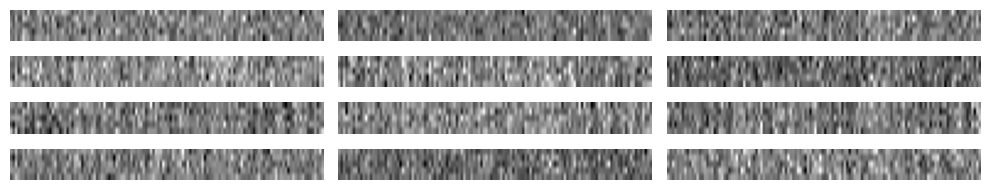

In [128]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the model from the file
# model_path = 'dbpedia_cnn.h5'
# model = tf.keras.models.load_model(model_path)

# Access the weights of the first Conv1D layer
conv1d_weights, conv1d_biases = model.layers[2].get_weights()

# Normalize the weights for better visualization
normalized_weights = (conv1d_weights - conv1d_weights.min()) / (conv1d_weights.max() - conv1d_weights.min())

# Let's visualize only the first n filters
n_filters = 12
n_columns = 3
n_rows = n_filters // n_columns + (n_filters % n_columns > 0)
fig, axes = plt.subplots(n_rows, n_columns, figsize=(10, n_rows * 0.5))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i in range(n_filters):
    # Get the weights of the i-th filter. The weights have shape (kernel_size, input_channels, output_channels)
    # Since we are visualizing the first layer filters, input_channels corresponds to the embedding dimension
    filter_weights = normalized_weights[:, :, i]
    
    # We might need to reshape or adjust dimensions to visualize the 2D structure of the filter
    # This depends on the exact shape of your filters
    ax = axes[i]
    ax.imshow(filter_weights, cmap='gray', aspect='auto')
    ax.axis('off')

# If we have less than n_filters (e.g., the last row), turn off the remaining axes
for i in range(n_filters, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [107]:
def compute_saliency_maps(model, input_data, class_idx, layer_index):
    # Create a sub-model that includes layers up to the layer of interest
    sub_model = tf.keras.models.Sequential(model.layers[:layer_index+1])

    with tf.GradientTape() as tape:
        # Convert input to a tensor and watch it
        inputs = tf.convert_to_tensor(input_data, dtype=tf.float32)
        tape.watch(inputs)

        # Forward pass through the sub-model
        intermediate_output = sub_model(inputs)

        # Continue the forward pass through the original model
        predictions = model(inputs)
        class_output = predictions[:, class_idx]

    # Compute gradients with respect to the intermediate output
    gradients = tape.gradient(class_output, intermediate_output)

    if gradients is None:
        raise ValueError("Gradients are None. Check if the layer's output is correctly linked to model outputs.")

    # Process gradients for visualization
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)[0]
    return saliency


In [108]:
# Predict the class and get its index
class_idx = np.argmax(model.predict(padded_sequence))
print(class_idx)

# Compute the saliency map
saliency_map = compute_saliency_maps(model, padded_sequence, class_idx, 2)

plt.figure(figsize=(20, 2))
plt.imshow(saliency_map.reshape(1, -1), cmap='hot', aspect='auto')
plt.colorbar()
plt.title("Saliency Map")
plt.xlabel("Character Index in the Input Sequence")
plt.ylabel("Saliency")
plt.show()

1/1 [==============================] - 0s 33ms/step
0


ValueError: Gradients are None. Check if the layer's output is correctly linked to model outputs.

In [129]:
from tensorflow.keras.models import Model

# Assuming your model is named 'model'
layer_outputs = [layer.output for layer in model.layers[1:]]  # Exclude the input layer
activation_model = Model(inputs=model.input, outputs=layer_outputs)


1/1 [==============================] - 0s 74ms/step
6
(1, 1495, 128)
128


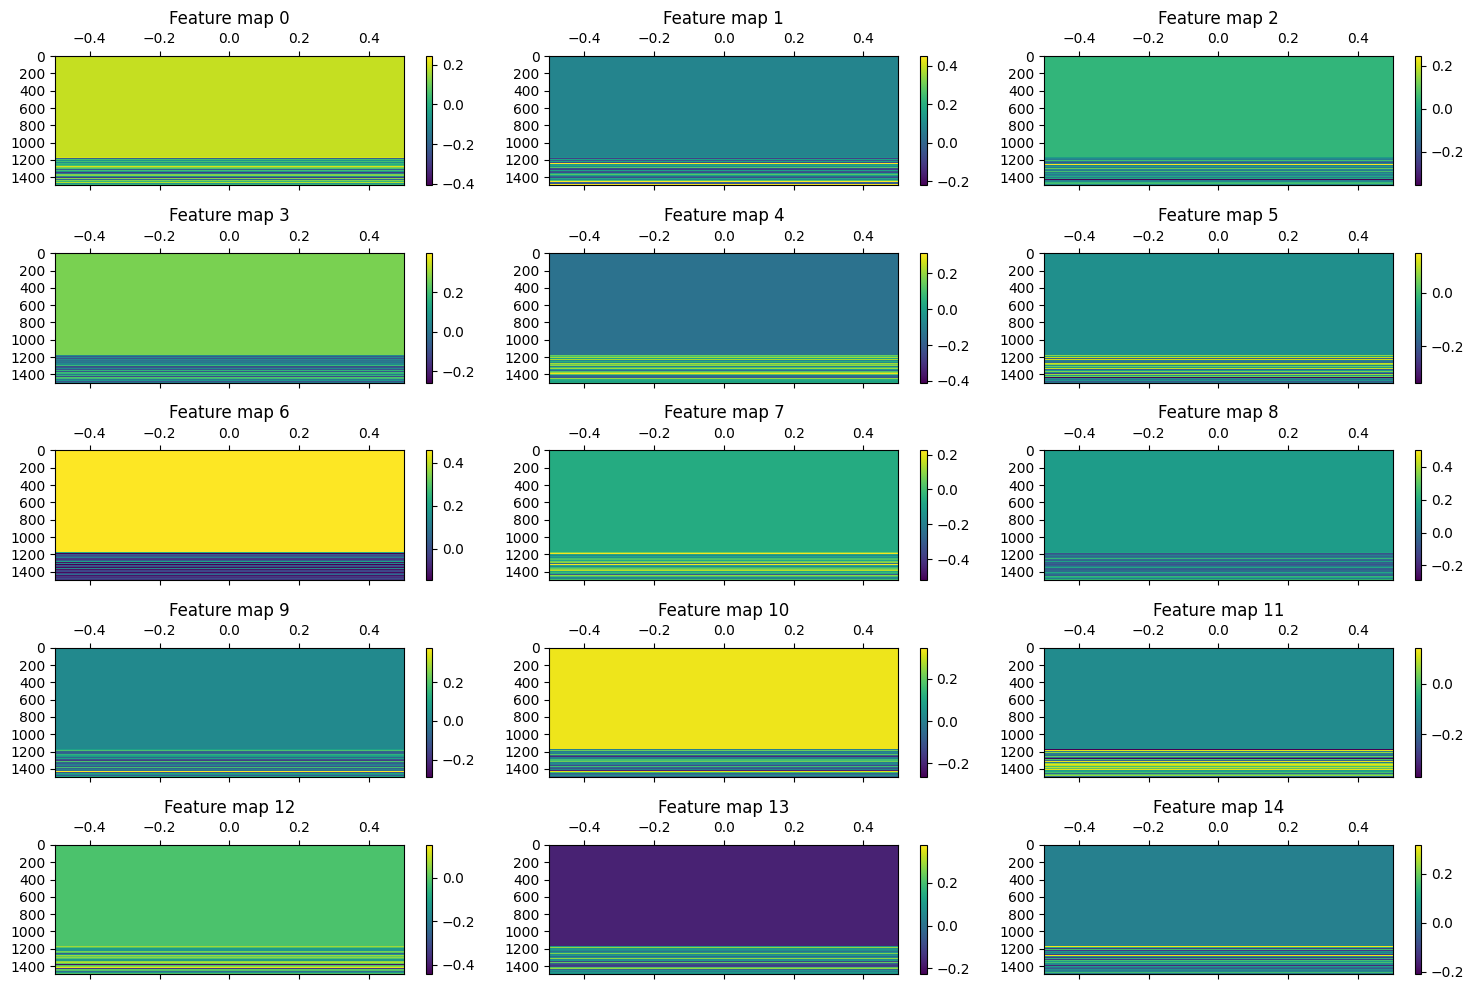

In [130]:
activations = activation_model.predict(padded_sequence)

print(len(activations))  # Should be equal to the number of layers in the model

# Let's visualize the activations of the first convolutional layer
first_layer_activations = activations[0]  # Adjust index based on your model structure

print(first_layer_activations.shape)  # Should be equal to (1, 100, 128

import matplotlib.pyplot as plt

# Number of features in the feature map
n_features = first_layer_activations.shape[2]  # The third dimension represents the number of features

print(n_features)

# Number of features to display
n = min(15, n_features)  # We choose 64 or the total number of features, whichever is smaller

# Set up the subplot grid
n_cols = 3  # Number of columns
n_rows = n // n_cols + (n % n_cols > 0)  # Calculate the necessary number of rows

plt.figure(figsize=(15, 2 * n_rows))  # Adjust figure size as needed

for i in range(n):
    # Reshape the feature map to 2D
    feature_map = first_layer_activations[0, :, i]
    feature_map_reshaped = feature_map.reshape(-1, 1)

    # Create a subplot for each feature map
    plt.subplot(n_rows, n_cols, i + 1)
    plt.matshow(feature_map_reshaped, fignum=False, cmap='viridis', aspect='auto')
    plt.title(f"Feature map {i}")
    plt.colorbar()  # Add a color bar for reference

plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()